# Gap filling - incomplete TI

>  **Note** This notebook is inspired from the notebook [ex_deesse_10_incomplete_image.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_10_incomplete_image.ipynb) by Julien Straubhaar.

MPS (and in particular, the DS or "Deesse" implementation) can be also used to fill the gaps in some images that present "holes", by doing the hypothesis that the patterns of heterogeneity that are missing are simular to the ones of the surrounding locations, which are used as training image.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

## Read the incomplete (training) image

Read the incomplete image from the file `ti_inc.txt`. The places where the information about the code is missing contain the "no-data" value `-9999999`. The cell that contains this reference value is said *uninformed cell*.

In [2]:
im = gn.img.readImageTxt('ti_inc.txt', missing_value=-9999999)

# Unique values
im.get_unique()

array([0., 1., 2.])

Plot the incomplete image

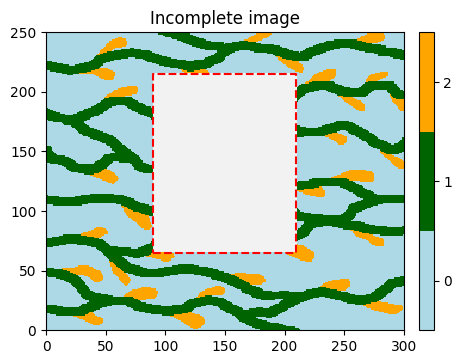

In [3]:
# Setting for categories / colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'darkgreen', 'orange']

# Set lines delineating the missing part
ind = np.where(np.isnan(im.val))
iy0, iy1 = ind[2].min(), ind[2].max()
ix0, ix1 = ind[3].min(), ind[3].max()
x0 =  im.x()[ix0] - 0.5*im.sx
x1 =  im.x()[ix1] + 0.5*im.sx
y0 =  im.y()[iy0] - 0.5*im.sy
y1 =  im.y()[iy1] + 0.5*im.sy
line_x = [x0, x1, x1, x0, x0]
line_y = [y0, y0, y1, y1, y0]

# Plot
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(im, categ=True, categVal=categ_val, categCol=categ_col, title='Incomplete image')
plt.plot(line_x, line_y, c='red', ls='dashed')
plt.show()

## Reconstruction of the image
The Direct Sampling algorithm (here "Deesse") can be used to reconstruct the missing part of the image, i.e. to simulate the variable in uninformed cells. In this case, the (incomplete) image serves as both training image *and* as hard conditioning data. This image can be called *training data set*.

> **Remark:** of course, an incomplete training image can be used for simulation on a different simulation grid with or without hard data.

## Set up the parameters for the simulation

In [4]:
nreal = 20 # Set this to 20 or more if you are working locally or you have access to more CPU ressources
deesse_input = gn.deesseinterface.DeesseInput(
    nx=im.nx, ny=im.ny, nz=im.nz, # set same dimensions grid as for the incomplete image
    sx=im.sx, sy=im.sy, sz=im.sz, # set same cell units grid as for the incomplete image
    ox=im.ox, oy=im.oy, oz=im.oz, # set same origin grid as for the incomplete image
    nv=1, varname=im.varname,     # number of variable(s), name of the variable(s), 
                                  #    as for the incomplete image
    TI=im,                        # set the incomplete image as TI
    dataImage=im,                 # set the incomplete image as hard data
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

## Run the simulation

In [5]:
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads=4)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
DeeSse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00010: a variable in a training image is not exhaustively informed


## Retrieve the reconstructed images, do some statistics (and display)

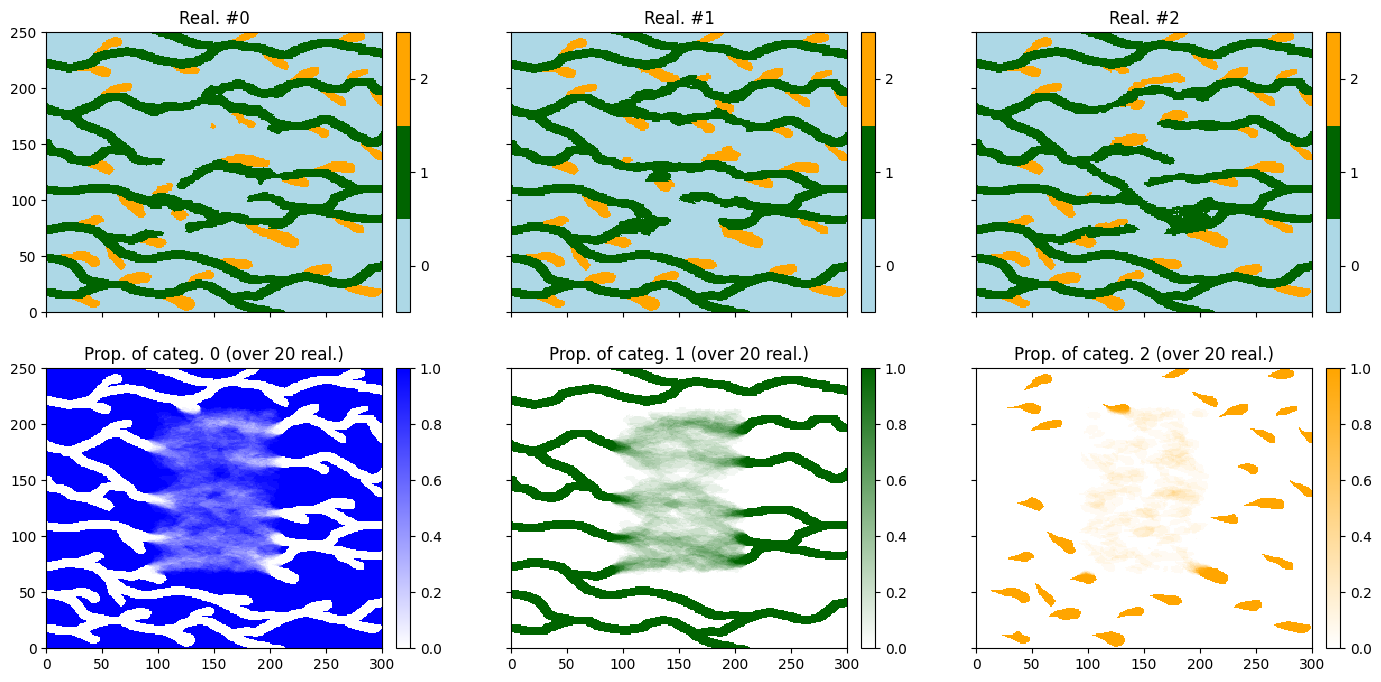

In [6]:
# Retrieve the results
sim = deesse_output['sim']

# Do some statistics on the realizations
# compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageListCategProp(sim, categ_val)

# Color map for proportion of each category
prop_col=['blue', 'darkgreen', 'orange'] # colors for the proportion maps
prop_cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Display
plt.subplots(2, 3, figsize=(17,8), sharex=True, sharey=True) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categVal=categ_val, categCol=categ_col)
    #plt.plot(line_x, line_y, c='red', ls='dashed') # add line delineating the reconstructed part
    plt.title(f'Real. #{i}')

for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=prop_cmap[i],
                           title=f'Prop. of categ. {i} (over {nreal} real.)')
    #plt.plot(line_x, line_y, c='black', ls='dashed') # add line delineating the reconstructed part
plt.show()

## Concluding remark - Reconstruction using pyramids

The quality and the connectivity of the results can be strongly improved by making use of the "pyramids", an advanced feature that allows to perform multi-resolution simulations. For more details about this, please see the original version of this notebook ([ex_deesse_10_incomplete_image.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_10_incomplete_image.ipynb)) and also the notebook [ex_deesse_16_advanced_use_of_pyramids.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_deesse_16_advanced_use_of_pyramids.ipynb).